# Сегментация космических аппаратов

## Загрузка данных

Данные хранятся в гугл диске — https://drive.google.com/drive/u/0/folders/1Q1wR9aBFCyeFEYa3wwyXNu9wk_fZdzUm

Для быстрой загрузки данных достаточно добавить ярлык папки Final_dataset в свой диск.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# !ls drive/MyDrive/Final_dataset

all_bbox.txt  images  mask  ReadMe.txt


In [1]:
!ls /kaggle/input/spacecraft-segmentation

ReadMe.txt  all_bbox.txt  images  mask


## Импорт библиотек

In [3]:
import os
import ast
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tqdm import tqdm

from tensorflow.keras import layers
import tensorflow.keras.backend as K
import keras
from tensorflow.keras.callbacks  import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# images_path = 'drive/MyDrive/Final_dataset/images/'
# masks_path = 'drive/MyDrive/Final_dataset/mask/'

images_path = '/kaggle/input/spacecraft-segmentation/images/'
masks_path = '/kaggle/input/spacecraft-segmentation/mask/'

## Знакомство с данными

Выведем содержимое README-файла — там важная информация о данных.

In [4]:
with open(
    # '/content/drive/MyDrive/Final_dataset/ReadMe.txt',
    '/kaggle/input/spacecraft-segmentation/ReadMe.txt',
    'r'
    ) as readme_file:
    readme_text = readme_file.read()
    print(readme_text)

#A satellite dataset for object detection and segmentation using both synthesis and real satellite images.

#This dataset include 3116 images, mask with size 1280x720 and bounding boxes of both synthesis and real satellite images. Each satellite is segmented into at most 3 parts, including body, solar panel and antena by respectively 3 color: green,red,blue.

#Image with index 0-1002 has fine mask while images from index 1003-3116 has coarse masks.
The datasets is divided into 2 parts: train data including 403 fine mask from index 0-402 and 2114 coarse mask from index 1003-3116. The val dataset includes 600 images with fine mask indexed from 403 to 1002.

#File all_bbox.txt include bounding boxes of all satellites inside datasets based on segmentation masks in form of a dictionary with index of images as key. Each bounding boxes has format [max_x,max_y,min_x,min_y].



In [5]:
train_imgs_paths = sorted([
    os.path.join(images_path, 'train', fname) for fname in os.listdir(images_path + 'train')
    ])
valid_imgs_paths = sorted([
    os.path.join(images_path, 'val', fname) for fname in os.listdir(images_path + 'val')
    ])

ttl_num_of_imgs = len(train_imgs_paths) + len(valid_imgs_paths)

print(f'This dataset include {ttl_num_of_imgs} images.')
print(f'Train data including {len(train_imgs_paths)} images.')
print(f'Valid data including {len(valid_imgs_paths)} images.')
print()

train_msks_paths = sorted([
    os.path.join(masks_path, 'train', fname) for fname in os.listdir(masks_path + 'train')
    ])
valid_msks_paths = sorted([
    os.path.join(masks_path, 'val', fname) for fname in os.listdir(masks_path + 'val')
    ])
ttl_num_of_msks = len(train_msks_paths) + len(valid_msks_paths)

print(f'This dataset include {ttl_num_of_msks} masks.')
print(f'Train data including {len(train_msks_paths)} masks.')
print(f'Valid data including {len(valid_msks_paths)} masks.')

This dataset include 3117 images.
Train data including 2517 images.
Valid data including 600 images.

This dataset include 3117 masks.
Train data including 2517 masks.
Valid data including 600 masks.


Число изображений может быть подсчитано с ошибкой (в google colab), потому что в папках лежали файлы метаданных MacOS:

In [6]:
for filename in train_imgs_paths + valid_imgs_paths:
    if 'img' not in filename:
        print(filename)

drive/MyDrive/Final_dataset/images/train/.DS_Store

drive/MyDrive/Final_dataset/images/val/.DS_Store


Удалим этот файл из списков:

In [7]:
train_imgs_paths.remove('drive/MyDrive/Final_dataset/images/train/.DS_Store')
valid_imgs_paths.remove('drive/MyDrive/Final_dataset/images/val/.DS_Store')

print(f'Train data including {len(train_imgs_paths)} images.')
print(f'Valid data including {len(valid_imgs_paths)} images.')

Train data including 2517 images.

Valid data including 600 images.


Восстановим словарь из текстового документа с информацией об ограничивающих рамках.

In [6]:
with open(
    # '/content/drive/MyDrive/Final_dataset/all_bbox.txt',
    '/kaggle/input/spacecraft-segmentation/all_bbox.txt',
    'r'
    ) as bboxes_file:
    bboxes = bboxes_file.read()
    bboxes_dict = ast.literal_eval(bboxes)

print('-'*40)
for i in range(3):
    k = list(bboxes_dict.keys())[i]
    v = bboxes_dict[list(bboxes_dict.keys())[i]]
    print(f'Image idx: {k}')
    print('Image bboxes:', *v, sep='\n')
    if i != 2:
        print()
print('-'*40, '\n')
print(f'Number of images in the dataset: {len(bboxes_dict)}')

objects_num = sum([len(lst) for lst in list(bboxes_dict.values())])

print(f'Number of objects in the dataset: {objects_num}')

bboxes_df = pd.DataFrame(
    bboxes_dict.items(), columns=['img_idx', 'bboxes']
    )
bboxes_df['num_of_bboxes_in_img'] = bboxes_df['bboxes'].apply(lambda x: len(x))
bboxes_df.num_of_bboxes_in_img.value_counts()

----------------------------------------
Image idx: 1003
Image bboxes:
[1142.0, 547.0, 296.0, 135.0]

Image idx: 1004
Image bboxes:
[728.0, 198.0, 542.0, 59.0]
[212.0, 305.0, 0.0, 118.0]
[1279.0, 437.0, 768.0, 85.0]

Image idx: 1005
Image bboxes:
[1214.0, 582.0, 322.0, 32.0]
---------------------------------------- 

Number of images in the dataset: 3117
Number of objects in the dataset: 3670


num_of_bboxes_in_img
1     2757
2      250
3       63
4       30
5        9
6        3
8        2
7        2
11       1
Name: count, dtype: int64

Большая часть изображений содержит лишь одну ограничивающую рамку, к чему при беглом осмотре масок должны быть вопросы, т.к. чаще всего встречаются аппараты с солнечными панелями. Вероятно, ограничивающие рамки, которыми снабдили нас авторы датасета, относятся к аппарату в целом.

In [7]:
class2color = {
    'background': 'black', 'solar panel': 'red',
    'body': 'green', 'antenna': 'blue'
    }
color2index = {'black': 0, 'red': 1, 'green': 2, 'blue': 3}
index2value = {0: (0, 0, 0), 1: (255, 0, 0), 2: (0, 255, 0), 3: (0, 0, 255)}
value2index = {tuple(v): k for k, v in index2value.items()}

In [8]:
def convert_target(target, value_to_index):
    """
    convert target segmentation map to [H, W, 1],
    where last channel is the index of the class.

    NOTE:
    We will later use sparse categorical cross entropy as loss

    """
    seg_map = np.zeros((target.shape[:2]), dtype="uint8")
    for val, id_ in value_to_index.items():
        seg_map[(target==list(val)).all(axis=2)] = id_
    return seg_map.reshape(target.shape[0], target.shape[1], 1)

/kaggle/input/spacecraft-segmentation/images/train/img_resize_1090.png


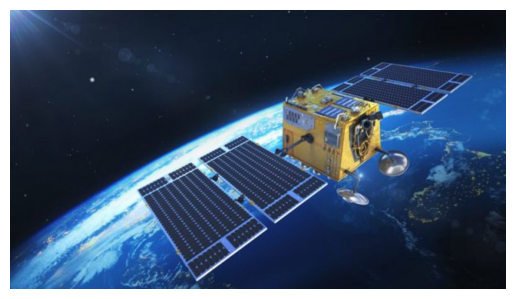

In [9]:
plt.axis("off")
train_img_path = train_imgs_paths[100]
print(train_img_path)
plt.imshow(load_img(train_img_path));

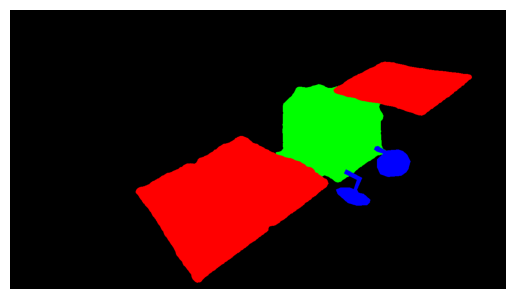

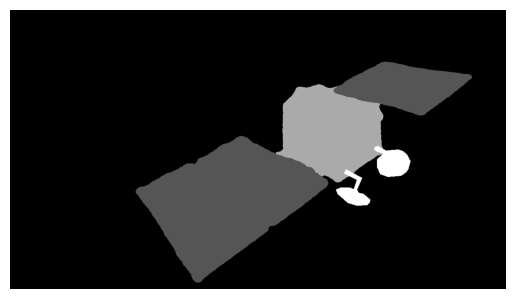

In [10]:
mask_path = train_img_path.split('.')[0] + '_mask.png'
mask_path = mask_path.replace('images', 'mask')
plt.axis("off")
tr = img_to_array(load_img(mask_path))
plt.imshow(tr.astype("uint8"), cmap='gray')
plt.show()
seg = convert_target(tr.astype("uint8"), value2index)
plt.axis("off")
plt.imshow(seg, cmap='gray')
plt.show()

## Подготовка данных

In [9]:
IMG_SIZE = (320, 320)
num_train_imgs = len(train_imgs_paths)
num_valid_imgs = len(valid_imgs_paths)

def get_img_from_path(path):
    return img_to_array(load_img(path, target_size=IMG_SIZE))

def get_target_from_path(path):
    img = img_to_array(load_img(path, target_size=IMG_SIZE,))
    img = convert_target(img.astype("uint8"), value2index)
    return img

input_train_imgs = np.zeros((num_train_imgs,) + IMG_SIZE +(3,), dtype="float32")
train_trgts = np.zeros((num_train_imgs,) + IMG_SIZE +(1,), dtype="uint8")

input_valid_imgs = np.zeros((num_valid_imgs,) + IMG_SIZE +(3,), dtype="float32")
valid_trgts = np.zeros((num_valid_imgs,) + IMG_SIZE +(1,), dtype="uint8")

for i in tqdm(range(num_train_imgs)):
    input_train_imgs[i] = get_img_from_path(train_imgs_paths[i])/255.
    mask_path = train_imgs_paths[i].split('.')[0] + '_mask.png'
    mask_path = mask_path.replace('images', 'mask')
    train_trgts[i] = get_target_from_path(mask_path)

for i in tqdm(range(num_valid_imgs)):
    input_valid_imgs[i] = get_img_from_path(valid_imgs_paths[i])/255.
    mask_path = valid_imgs_paths[i].split('.')[0] + '_mask.png'
    mask_path = mask_path.replace('images', 'mask')
    valid_trgts[i] = get_target_from_path(mask_path)

100%|██████████| 600/600 [00:42<00:00, 14.26it/s]


In [10]:
#test-validation split
valid_inputs, test_inputs, valid_targets, test_targets = train_test_split(
    input_valid_imgs, valid_trgts ,test_size=0.50, random_state=42
    )

In [11]:
#Data loaders for train and validation data

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 4


train_dataloader = tf.data.Dataset.from_tensor_slices(
    (input_train_imgs, train_trgts)
    )
valid_dataloader = tf.data.Dataset.from_tensor_slices(
    (valid_inputs, valid_targets)
    )
test_dataloader = tf.data.Dataset.from_tensor_slices(
    (test_inputs, test_targets)
    )

trainloader = (
    train_dataloader
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

validloader = (
    valid_dataloader
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [12]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
    plt.show()

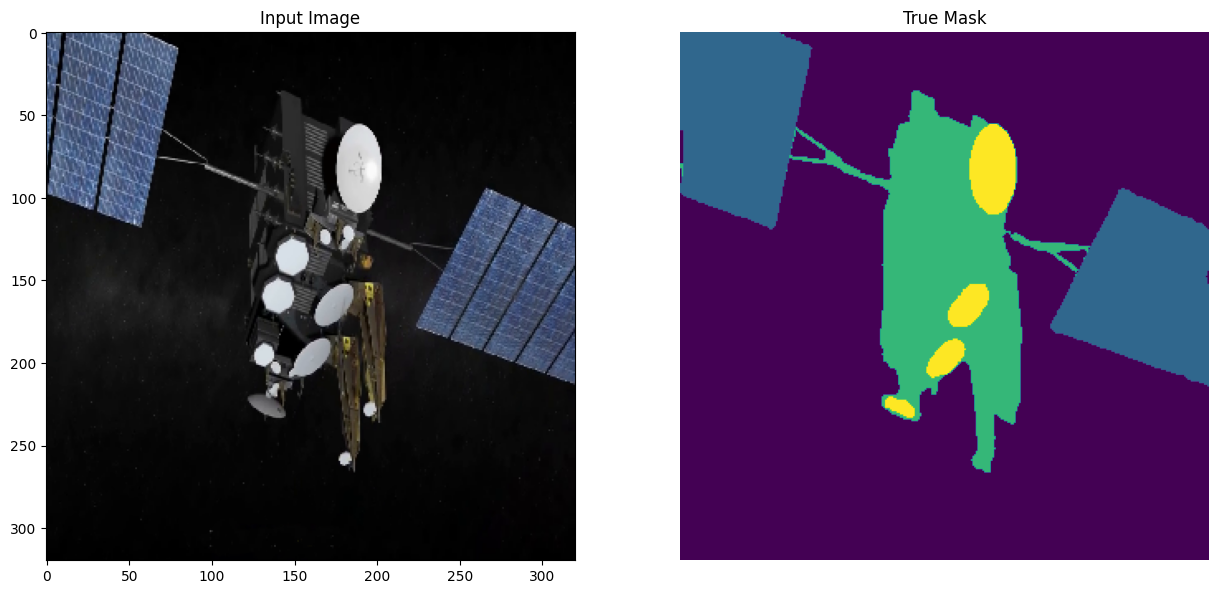

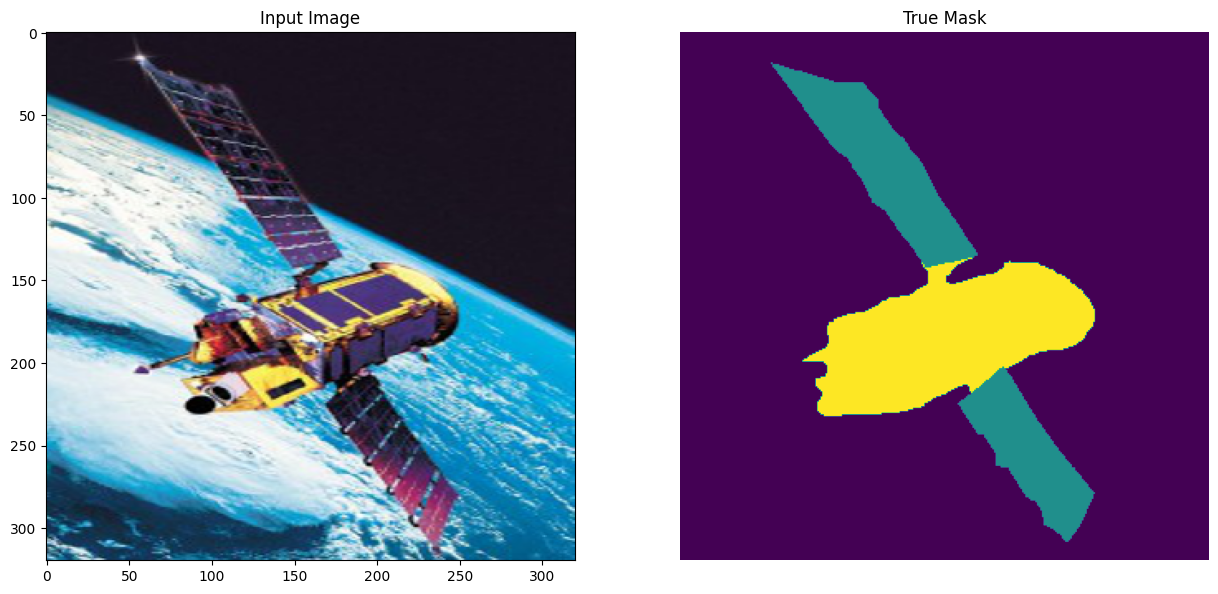

In [16]:
for images, masks in trainloader.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

## Создание модели U-NET

In [13]:
NUM_CLASSES = 4

def get_UNET(img_size, num_classes=NUM_CLASSES):

    #encoder
    inputs = keras.Input(shape=img_size +(3,))

    conv1_1 = layers.Conv2D(16, 3, padding="same")(inputs)
    bn1_1 = layers.BatchNormalization()(conv1_1)
    bn1_1 = layers.LeakyReLU()(bn1_1)
    conv1_2 = layers.Conv2D(16, 3, padding="same")(bn1_1)
    bn1_2 = layers.BatchNormalization()(conv1_2)
    bn1_2 = layers.LeakyReLU()(bn1_2)
    max_pool_1 = layers.MaxPooling2D((2, 2))(bn1_2)
    resedual1 = layers.Conv2D(32,1,padding="same")(max_pool_1)

    conv2_1 = layers.Conv2D(32 ,3, padding="same")(max_pool_1)
    bn2_1 = layers.BatchNormalization()(conv2_1)
    bn2_1 = layers.LeakyReLU()(bn2_1)
    conv2_2 = layers.Conv2D(32 ,3, padding="same")(bn2_1)
    bn2_2 = layers.BatchNormalization()(conv2_2)
    bn2_2 = layers.add([bn2_2, resedual1])
    bn2_2 = layers.LeakyReLU()(bn2_2)
    max_pool_2 = layers.MaxPooling2D((2, 2))(bn2_2)
    resedual2 = layers.Conv2D(64,1,padding="same")(max_pool_2)

    conv3_1 = layers.Conv2D(64 ,3, padding="same")(max_pool_2)
    bn3_1 = layers.BatchNormalization()(conv3_1)
    bn3_1 = layers.LeakyReLU()(bn3_1)
    conv3_2 = layers.Conv2D(64 ,3, padding="same")(bn3_1)
    bn3_2 = layers.BatchNormalization()(conv3_2)
    bn3_2 = layers.add([bn3_2, resedual2])
    bn3_2 = layers.LeakyReLU()(bn3_2)
    max_pool_3 = layers.MaxPooling2D((2, 2))(bn3_2)
    resedual3 = layers.Conv2D(128,1,padding="same")(max_pool_3)


    conv4_1 = layers.Conv2D(128 ,3, padding="same")(max_pool_3)
    bn4_1 = layers.BatchNormalization()(conv4_1)
    bn4_1 = layers.LeakyReLU()(bn4_1)
    conv4_2 = layers.Conv2D(128 ,3, padding="same")(bn4_1)
    bn4_2 = layers.BatchNormalization()(conv4_2)
    bn4_2 = layers.add([bn4_2, resedual3])
    bn4_2 = layers.LeakyReLU()(bn4_2)
    conv4_3 = layers.Conv2D(128 ,3, padding="same")(bn4_2)
    bn4_3 = layers.BatchNormalization()(conv4_3)
    bn4_3 = layers.LeakyReLU()(bn4_3)

    conv5_1 = layers.Conv2D(64 ,3, padding="same")(bn4_3)
    bn5_1 = layers.BatchNormalization()(conv5_1)
    bn5_1 = layers.LeakyReLU()(bn5_1)
    conv5_2 = layers.Conv2D(64 ,3, padding="same")(bn5_1)
    bn5_2 = layers.BatchNormalization()(conv5_2)
    bn5_2 = layers.LeakyReLU()(bn5_2)
    conv5_3 = layers.Conv2D(64 ,3, padding="same")(bn5_2)
    bn5_3 = layers.BatchNormalization()(conv5_3)
    bn5_3 = layers.LeakyReLU()(bn5_3)
    resedual5 = layers.Conv2DTranspose(32, 2, strides=(2,2), padding="same")(bn5_3)
    resedual5 = layers.Conv2D(32, 1, padding="same")(resedual5)

    #decoder

    conv6_up = layers.Conv2DTranspose(32, 3, strides = (2, 2), padding = 'same')(bn5_3)
    conv6_up = layers.BatchNormalization()(conv6_up)
    conv6_up = layers.add([conv6_up, resedual5])
    conv6_up = layers.concatenate([conv6_up, bn3_2])
    conv6_up = layers.LeakyReLU()(conv6_up)
    conv6_1 = layers.Conv2D(32 ,3, padding="same")(conv6_up)
    bn6_1 = layers.BatchNormalization()(conv6_1)
    bn6_1 = layers.LeakyReLU()(bn6_1)
    conv6_2 = layers.Conv2D(32 ,3, padding="same")(bn6_1)
    bn6_2 = layers.BatchNormalization()(conv6_2)
    bn6_2 = layers.LeakyReLU()(bn6_2)
    resedual6 = layers.Conv2DTranspose(16, 2, strides=(2,2), padding="same")(bn6_2)
    resedual6 = layers.Conv2D(16, 1, padding="same")(resedual6)


    conv7_up = layers.Conv2DTranspose(16, 3, strides = (2, 2), padding = 'same')(bn6_2)
    conv7_up = layers.BatchNormalization()(conv7_up)
    conv7_up = layers.add([conv7_up, resedual6])
    conv7_up = layers.concatenate([conv7_up, bn2_2])
    conv7_up = layers.LeakyReLU()(conv7_up)
    conv7_1 = layers.Conv2D(16 ,3, padding="same")(conv7_up)
    bn7_1 = layers.BatchNormalization()(conv7_1)
    bn7_1 = layers.LeakyReLU()(bn7_1)
    conv7_2 = layers.Conv2D(16 ,3, padding="same")(bn7_1)
    bn7_2 = layers.BatchNormalization()(conv7_2)
    bn7_2 = layers.LeakyReLU()(bn7_2)
    resedual7 = layers.Conv2DTranspose(num_classes, 2, strides=(2,2), padding="same")(bn7_2)
    resedual7 = layers.Conv2D(num_classes, 1, padding="same")(resedual7)


    conv8_up = layers.Conv2DTranspose(num_classes, 3, strides = (2, 2), padding = 'same')(bn7_2)
    conv8_up = layers.BatchNormalization()(conv8_up)
    conv8_up = layers.add([conv8_up, resedual7])
    conv8_up = layers.concatenate([conv8_up, bn1_2])
    conv8_up = layers.LeakyReLU()(conv8_up)
    conv8_1 = layers.Conv2D(num_classes ,3, padding="same")(conv8_up)
    bn8_1 = layers.BatchNormalization()(conv8_1)
    bn8_1 = layers.LeakyReLU()(bn8_1)
    conv8_2 = layers.Conv2D(num_classes ,3, padding="same")(bn8_1)
    bn8_2 = layers.BatchNormalization()(conv8_2)
    bn8_2 = layers.LeakyReLU()(bn8_2)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(bn8_2)
    model = keras.Model(inputs, outputs)
    return model

In [14]:
model = get_UNET(IMG_SIZE, num_classes=NUM_CLASSES)

In [27]:
# model.summary()

In [15]:
# Общее число параметров
total_params = model.count_params()
print('Общее число параметров:', total_params)

# Число обучаемых параметров
trainable_params = sum(
    [tf.keras.backend.count_params(w) for w in model.trainable_weights]
    )
print('Число обучаемых параметров:', trainable_params)

# Число необучаемых параметров
non_trainable_params = total_params - trainable_params
print('Число необучаемых параметров:', non_trainable_params)

Общее число параметров: 686312
Число обучаемых параметров: 684400
Число необучаемых параметров: 1912


In [16]:
def CE_dice_loss(y_true, y_pred, lamb1 = 0.2, lamb2= 0.8, gamma=1e-6):
    
    CE =  tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    
    y_true_dice = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=NUM_CLASSES))
    y_pred_dice = K.flatten(y_pred)
    
    intersect = K.sum(y_true_dice * y_pred_dice, axis=-1)
    denom = K.sum(y_true_dice * y_true_dice, axis=-1) + K.sum(y_pred_dice * y_pred_dice, axis=-1)
    
    dice_loss = 1- K.mean((2. * intersect + gamma) / (denom + gamma)) 
    
    return lamb1*CE + lamb2*(dice_loss)

In [17]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('/kaggle/working/unet_weights.keras', verbose=1, save_best_only=True)
]

## Обучение модели

In [29]:
# model.compile(optimizer='Adam', loss=CE_dice_loss)
# history = model.fit(
#     trainloader, epochs=100,
#     validation_data=validloader,
#     callbacks=callbacks
#     )

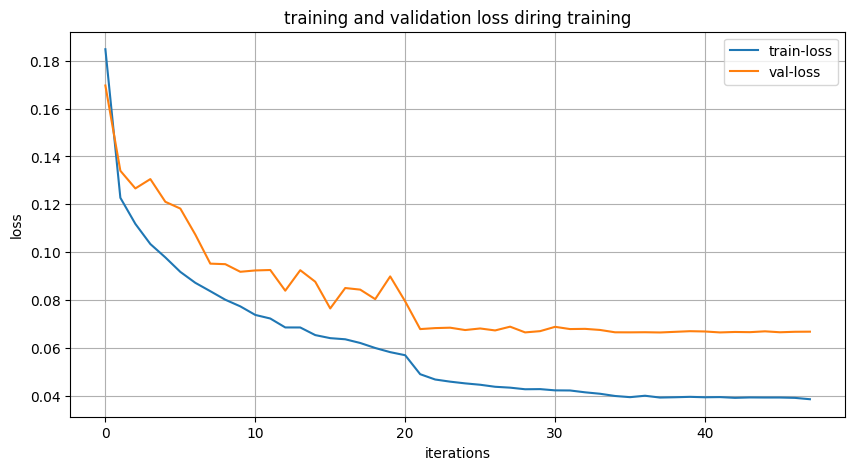

In [19]:
plt.figure(figsize=(10, 5))
training_history = history.history

plt.plot(range(len(training_history["loss"])), training_history["loss"], label="train-loss")
plt.plot(range(len(training_history["loss"])), training_history["val_loss"], label="val-loss")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.title("training and validation loss diring training")
plt.show()

## Прогнозирование и оценка тестовых данных

In [22]:
# loaded_model = keras.models.load_model(
#     "/kaggle/working/unet_weights.keras",
#     custom_objects={"CE_dice_loss":CE_dice_loss}
# )

# preds = np.argmax(loaded_model.predict(test_inputs), axis=-1)

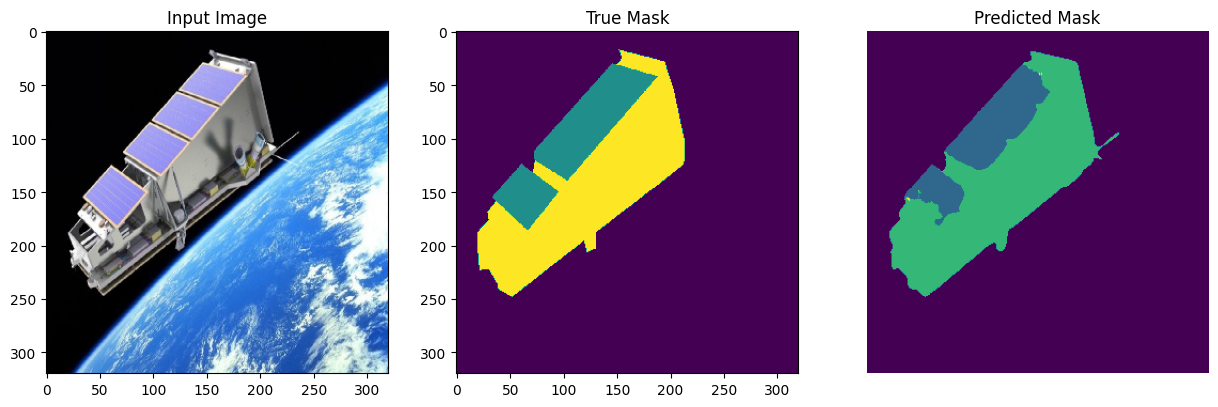

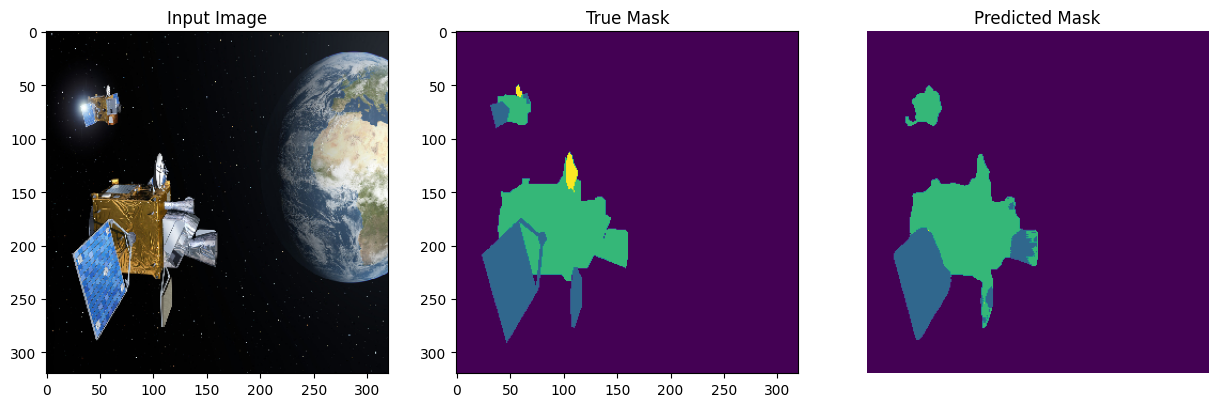

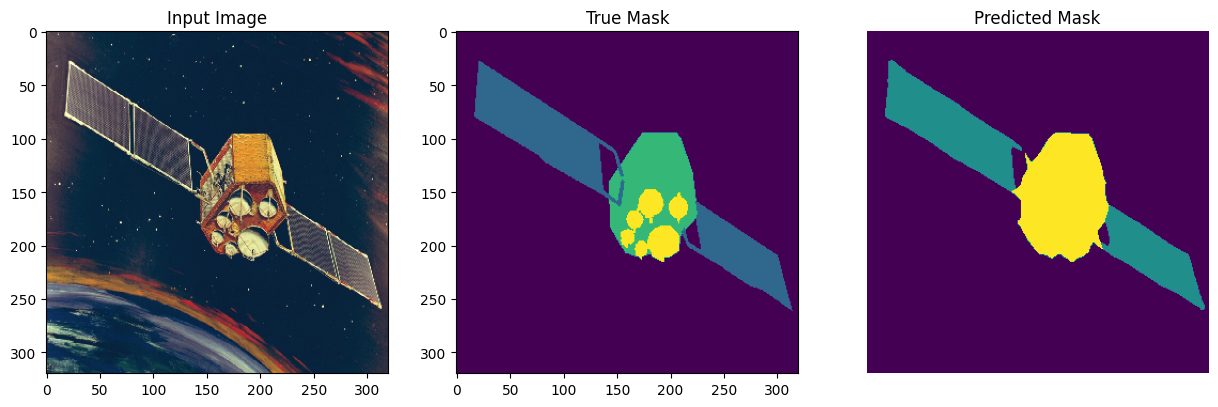

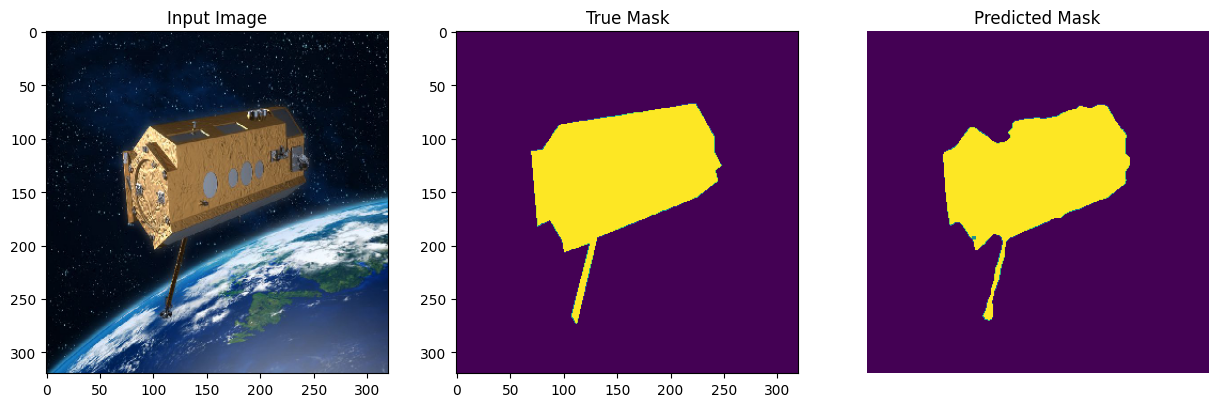

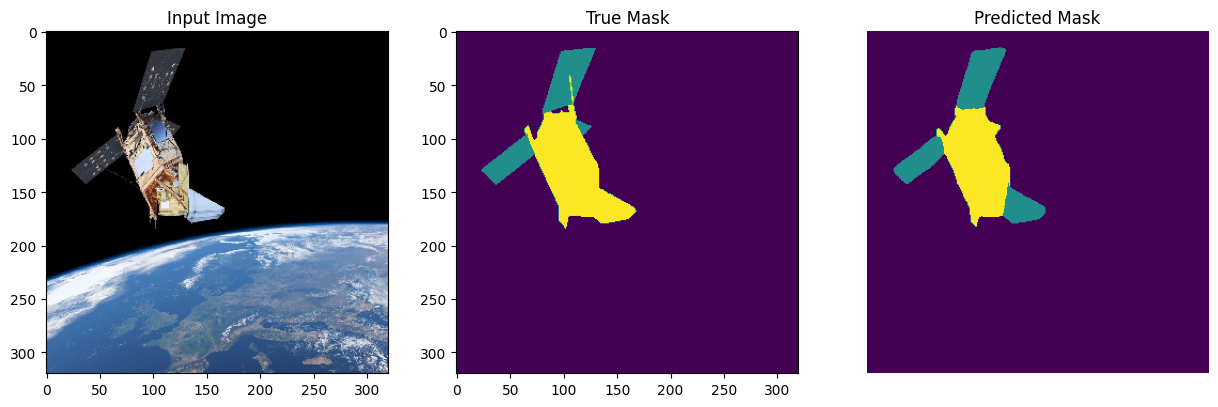

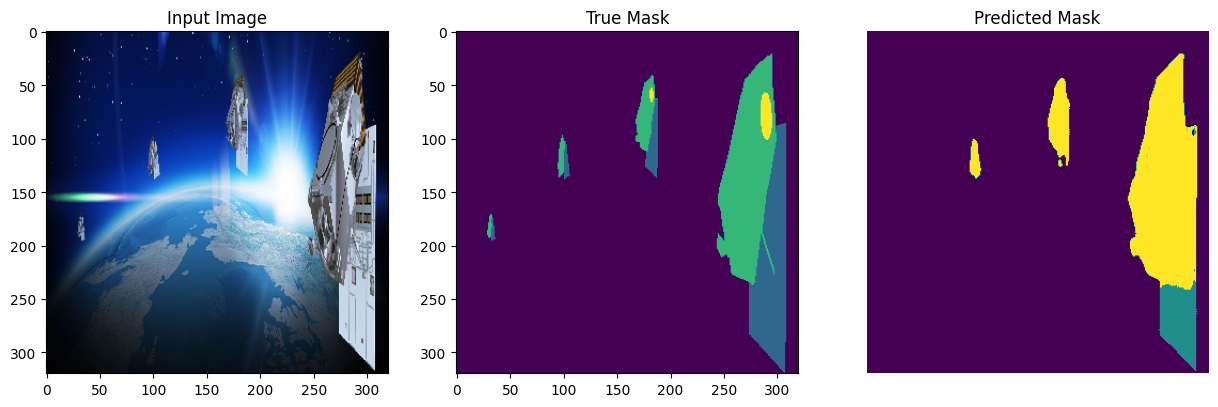

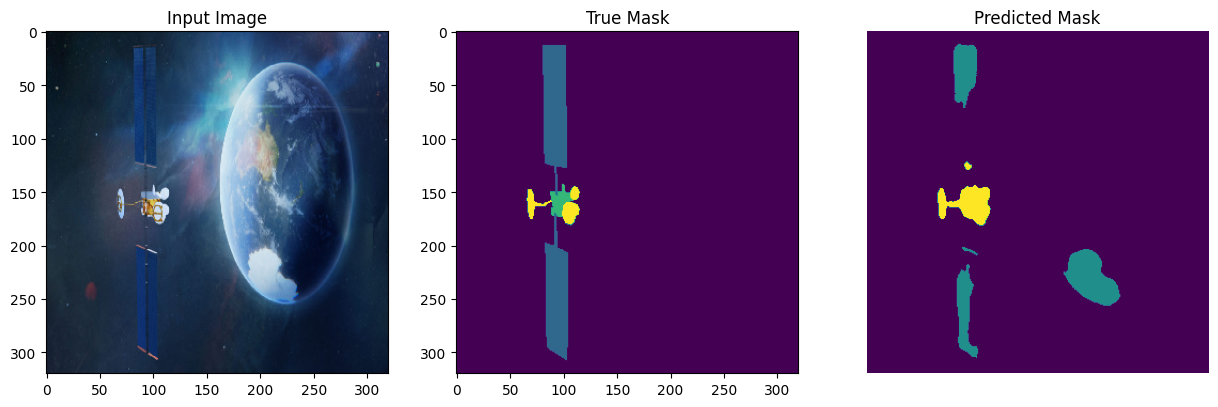

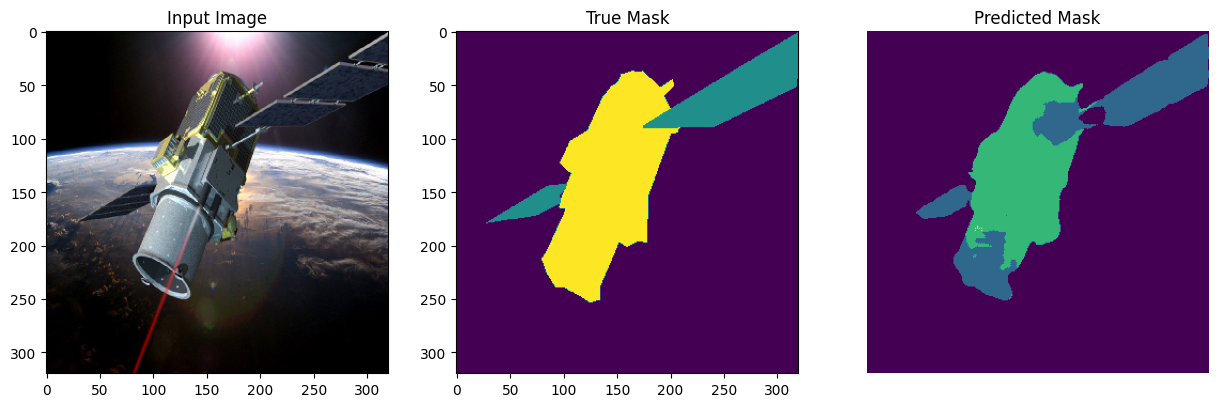

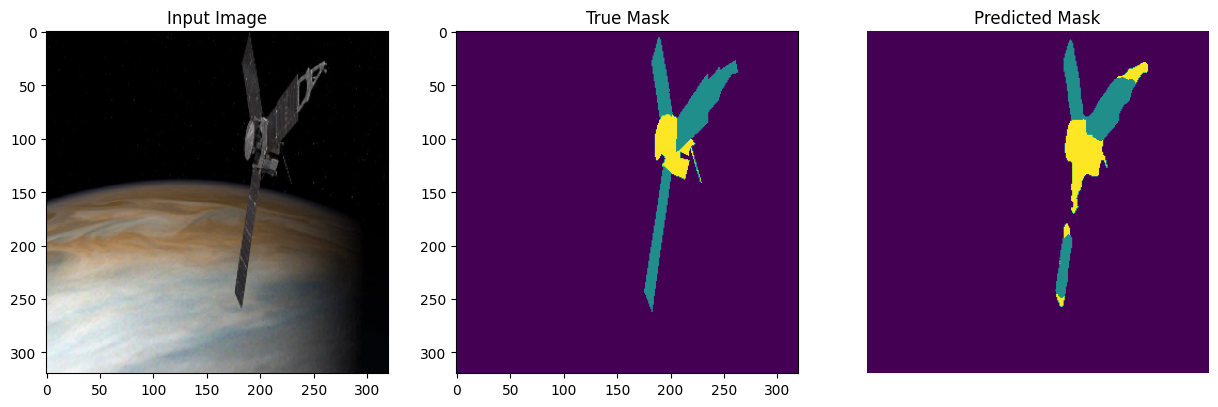

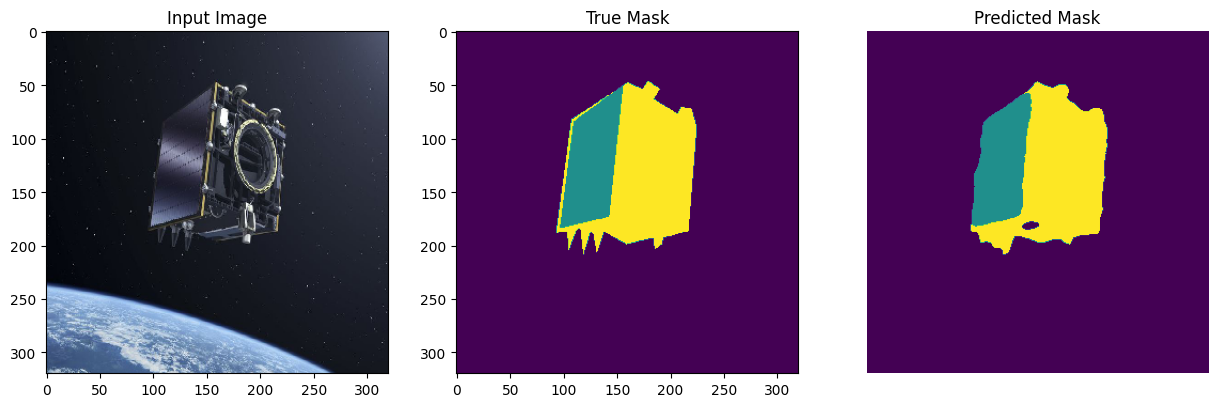

In [24]:
#qualitative results
for i in range(50,60):
    display(
        [test_inputs[i], test_targets[i], preds[i].reshape((320, 320, 1))]
        )

In [25]:
def IoU_metric(y_true, y_pred):
    num_classes = y_pred.shape[-1]
    y_true = y_true.reshape((y_true.shape[0], y_true.shape[1], y_true.shape[2]))
    y_pred = np.array([ np.argmax(y_pred, axis=-1)==i for i in range(num_classes) ]).transpose(1,2,3,0)
    y_true = np.array([ y_true == i for i in range(num_classes) ]).transpose(1,2,3,0)

    intersection = np.sum(np.logical_and(y_pred, y_true), axis=(1, 2))
    union = np.sum(np.logical_or(y_pred, y_true), axis=(1, 2))

    smooth = 1e-4
    iou = (intersection + smooth) / (union + smooth)
    return np.mean(iou)


def Dice_coeff(y_true, y_pred):
    num_classes = y_pred.shape[-1]
    y_true = y_true.reshape((y_true.shape[0], y_true.shape[1], y_true.shape[2]))
    y_pred = np.array([ np.argmax(y_pred, axis=-1)==i for i in range(num_classes) ]).transpose(1,2,3,0).astype("uint8")
    y_true = np.array([ y_true == i for i in range(num_classes) ]).transpose(1,2,3,0).astype("uint8")
    
    smooth = 1e-4
    numerator = np.sum(np.abs(y_pred * y_true), axis=(1, 2))
    denominator = np.sum(np.abs(y_true), axis=(1, 2)) + np.sum(np.abs(y_pred), axis=(1, 2))
    dice = (2 * (numerator) + smooth)/(denominator + smooth)
    
    return np.mean(dice)

In [26]:
sfmax_predictions = loaded_model.predict(test_inputs)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


In [27]:
mean_iou = IoU_metric(test_targets, sfmax_predictions)
mean_dice = Dice_coeff(test_targets, sfmax_predictions)
print(f'mIoU: {mean_iou:.4}')
print(f'mDС:  {mean_dice:.4}')

mIoU: 0.7014
mDС:  0.7565
